# 🧌 Monstrinho 3.1

> Este monstrinho é uma atividade à parte, onde não foi requisisitada pelo professor Daniel R. Cassar.

Neste monstrinho, vou utilizar dos conceitos aprendidos na aula de [AutoGrad](https://ilumcnpem-my.sharepoint.com/:v:/r/personal/daniel_cassar_ilum_cnpem_br/Documents/Material%20Did%C3%A1tico/Redes%20Neurais/ATP-303%20NN%203.1%20-%20Autograd.mp4) para resolver o Monstrinho 3.1 computacionalmente.

Então, vamos começar! 

Assim, como visto na aula, vamos começar definindo e construindo a função de criação do grafo computacional.

In [23]:
from graphviz import Digraph


def _tracar(folha):
    """Função modificada da criada por Andrej Karpathy para construção de grafo.

    Referência: https://github.com/karpathy/micrograd

    """
    vertices = set()
    arestas = set()

    def construir(v):
        """Função recursiva para traçar o grafo."""
        if v not in vertices:
            vertices.add(v)
            for progenitor in v.progenitor:
                arestas.add((progenitor, v))
                construir(progenitor)

    construir(folha)

    return vertices, arestas


def plota_grafo(folha):
    """Função modificada da criada por Andrej Karpathy para construção de grafo.

    Referência: https://github.com/karpathy/micrograd

    """
    grafo = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    vertices, arestas = _tracar(folha)

    for v in vertices:
        id_vertice = str(id(v))

        if hasattr(v, "rotulo") and (hasattr(v, "grad")):
            texto = "{ " + f"{v.rotulo} | data {v.data:.3f} | grad {v.grad:.3f}" + " }"

        elif hasattr(v, "rotulo"):
            texto = "{ " + f"{v.rotulo} | data {v.data:.3f}" + " }"

        else:
            texto = "{ " + f"data {v.data:.3f}" + " }"

        grafo.node(name=id_vertice, label=texto, shape="record")

        if v.operador_mae:
            grafo.node(name=id_vertice + v.operador_mae, label=v.operador_mae)
            grafo.edge(id_vertice + v.operador_mae, id_vertice)

    for vertice1, vertice2 in arestas:
        grafo.edge(str(id(vertice1)), str(id(vertice2)) + vertice2.operador_mae)

    return grafo

In [24]:
import math

class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

In [25]:
def _tracar(folha):
    """Função modificada para construção do grafo (baseada em Karpathy)."""
    vertices = set()
    arestas = set()

    def construir(v):
        if v not in vertices:
            vertices.add(v)
            for progenitor in v.progenitor:
                arestas.add((progenitor, v))
                construir(progenitor)

    construir(folha)
    return vertices, arestas

def plota_grafo(folha, rankdir="LR", node_color="lightblue", operator_color="lightpink",
                fontname="Helvetica", fontsize="10", nodesep="0.5", ranksep="0.5"):
    """
    Plota o grafo com personalização estética.

    Args:
        folha: Nó final (saída) do grafo.
        rankdir: Direção do grafo (ex.: "LR" para left-to-right ou "TB" para top-to-bottom).
        node_color: Cor de fundo para nós de dados.
        operator_color: Cor de fundo para nós que representam operadores.
        fontname: Nome da fonte usada nos rótulos.
        fontsize: Tamanho da fonte.
        nodesep: Espaçamento entre nós.
        ranksep: Espaçamento entre níveis hierárquicos.
    """
    grafo = Digraph(format="svg", 
                    graph_attr={"rankdir": rankdir, "nodesep": nodesep, "ranksep": ranksep})
    vertices, arestas = _tracar(folha)

    for v in vertices:
        id_vertice = str(id(v))
        
        if hasattr(v, "rotulo") and hasattr(v, "grad"):
            texto = "{ " + f"{v.rotulo} | data: {v.data:.3f} | grad: {v.grad:.3f}" + " }"
        elif hasattr(v, "rotulo"):
            texto = "{ " + f"{v.rotulo} | data: {v.data:.3f}" + " }"
        else:
            texto = "{ " + f"data: {v.data:.3f}" + " }"
        
        # Define a cor de fundo conforme a existência de um operador associado.
        fillcolor = operator_color if v.operador_mae else node_color
        
        grafo.node(name=id_vertice, label=texto, shape="record", style="filled",
                   fillcolor=fillcolor, fontname=fontname, fontsize=fontsize)
        
        # Se houver um operador, crie um nó extra para ele e conecte-o ao nó principal.
        if v.operador_mae:
            op_id = id_vertice + v.operador_mae
            grafo.node(name=op_id, label=v.operador_mae, shape="ellipse", style="filled",
                       fillcolor="white", fontname=fontname, fontsize=fontsize)
            grafo.edge(op_id, id_vertice)

    for vertice1, vertice2 in arestas:
        tail = str(id(vertice1))
        head = str(id(vertice2))
        if vertice2.operador_mae:
            head = head + vertice2.operador_mae
        grafo.edge(tail, head)

    return grafo

In [34]:
from graphviz import Digraph
import math


def _tracar(folha):
    """Retorna uma lista de nós em ordem topológica a partir da folha."""
    ordem_topologica = []
    visitados = set()

    def dfs(v):
        if v not in visitados:
            visitados.add(v)
            for progenitor in v.progenitor:
                dfs(progenitor)
            ordem_topologica.append(v)

    dfs(folha)
    return ordem_topologica


def plota_grafo(
    folha,
    rankdir="LR",
    node_color="lightblue",
    operator_color="lightpink",
    fontname="Helvetica",
    fontsize="10",
    nodesep="0.5",
    ranksep="0.5",
):
    """
    Plota o grafo utilizando uma ordem topológica para exibição dos nós.
    """
    grafo = Digraph(
        format="svg",
        graph_attr={"rankdir": rankdir, "nodesep": nodesep, "ranksep": ranksep},
    )

    vertices_ordenados = _tracar(folha)
    vertices_set = set(vertices_ordenados)

    # Adiciona os nós na ordem definida:
    for v in vertices_ordenados:
        id_vertice = str(id(v))
        label_parts = []
        if hasattr(v, "rotulo") and v.rotulo:
            label_parts.append(f"{v.rotulo}")
        if hasattr(v, "nome") and v.nome:
            label_parts.append(f"{v.nome}")
        label_parts.append(f"{v.data}")
        if hasattr(v, "grad"):
            label_parts.append(f"{v.grad}")
        texto = "{ " + " | ".join(label_parts) + " }"

        fillcolor = operator_color if v.operador_mae else node_color

        grafo.node(
            name=id_vertice,
            label=texto,
            shape="record",
            style="filled",
            fillcolor=fillcolor,
            fontname=fontname,
            fontsize=fontsize,
        )

        if v.operador_mae:
            op_id = id_vertice + v.operador_mae
            grafo.node(
                name=op_id,
                label=v.operador_mae,
                shape="ellipse",
                style="filled",
                fillcolor="white",
                fontname=fontname,
                fontsize=fontsize,
            )
            grafo.edge(op_id, id_vertice)

    # Recria as arestas
    for v in vertices_set:
        for progenitor in v.progenitor:
            tail = str(id(progenitor))
            head = str(id(v))
            if v.operador_mae:
                head = head + v.operador_mae
            grafo.edge(tail, head)

    return grafo


# Exemplo de classe Valor com atributo opcional 'nome'
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo="", nome=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo  # rótulo principal, ex.: "a", "b"
        self.nome = nome  # nome extra, ex.: "s1", "p1"
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"

    def __add__(self, outro_valor):
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad

        resultado.propagar = propagar_adicao
        return resultado

    def __mul__(self, outro_valor):
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data
            outro_valor.grad += resultado.grad * self.data

        resultado.propagar = propagar_multiplicacao
        return resultado

    def exp(self):
        progenitor = (self,)
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_exp():
            self.grad += resultado.grad * data

        resultado.propagar = propagar_exp
        return resultado

    def __pow__(self, expoente):
        assert isinstance(expoente, (int, float))
        progenitor = (self,)
        data = self.data**expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))

        resultado.propagar = propagar_pow
        return resultado

    def __truediv__(self, outro_valor):
        return self * outro_valor ** (-1)

    def __neg__(self):
        return self * -1

    def __sub__(self, outro_valor):
        return self + (-outro_valor)

    def __radd__(self, outro_valor):
        return self + outro_valor

    def __rmul__(self, outro_valor):
        return self * outro_valor

    def sig(self):
        return self.exp() / (self.exp() + 1)

    def propagar(self):
        pass

    def propagar_tudo(self):
        self.grad = 1
        ordem_topologica = []
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

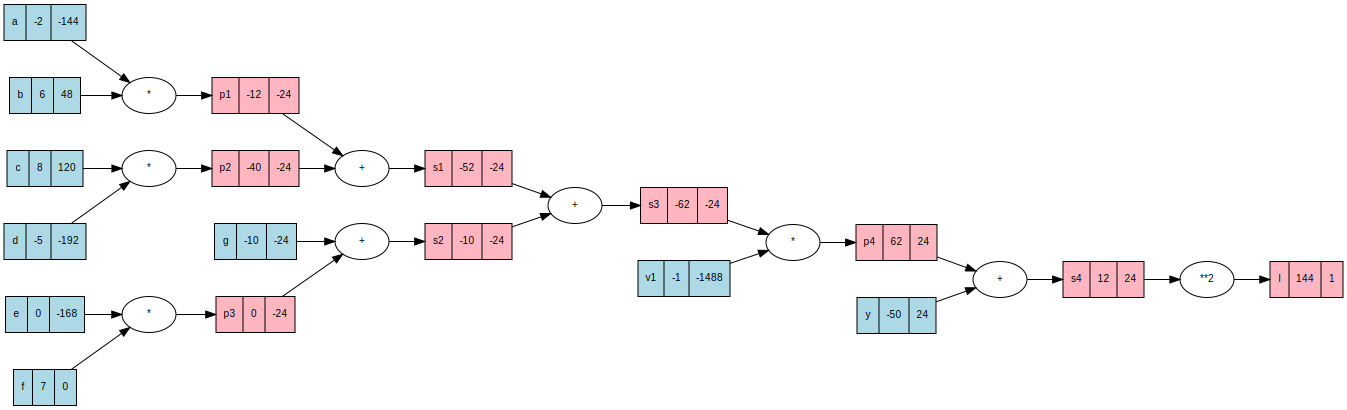

In [35]:
a = Valor(-2, rotulo="a")
b = Valor(6, rotulo="b")
c = Valor(8, rotulo="c")
d = Valor(-5, rotulo="d")
e = Valor(0, rotulo="e")
f = Valor(7, rotulo="f")
g = Valor(-10, rotulo="g")
y = Valor(-50, rotulo="y")
v1 = Valor(-1, rotulo="v1")

p1 = a * b
p1.nome = "p1"
p2 = c * d
p2.nome = "p2"
p3 = e * f
p3.nome = "p3"
s1 = p1 + p2
s1.nome = "s1"
s2 = p3 + g
s2.nome = "s2"
s3 = s1 + s2
s3.nome = "s3"
p4 = s3 * v1
p4.nome = "p4"
s4 = p4 + y
s4.nome = "s4"
l = pow(s4, 2)
l.nome = "l"

l.propagar_tudo()

plota_grafo(l)